# This shit needs cleaned up quite a bit, but good enough for hacking it together initially

### [This blog post](http://engineering.hackerearth.com/2014/08/21/python-requests-module/) was very helpful in getting it working right.

In [1]:
import pandas as pd

# Questions I'm hoping to find the answers to with this data?
- What was my most productive day of the week?  
  - How did it change over time?
- Visualizing total word count over time?
  - Need to do a more sophisticated pull of past commits and find a way to count the "words" in a .tex file


###### Can use [this blog post](http://blog.rtwilson.com/my-thesis-writing-timeline-analysed-using-dropbox-and-python/) to get some ideas on how to slice this data up

Word counting in Python using subprocess.Popen : texcount -brief -total -1 -sum file.tex

[TeXlog might be handy as well](https://github.com/deparkes/texlog)

Really need to figure out how to have python go through git history and visualize the word count over time

# Now working towards pulling all revisions of sykes_*.tex files in git history

# Outline
- For each file sykes_*.tex:
  - Get list of commits
  - For each commit:
    - Checkout repo at commit, grab file contents of file:
    - Run texcount -brief -total -1 -sum file.tex on checked-out file, save word count
- End with list of tuples, (file, commit, word_count)
- Continue with analysis by reshaping and grouping as needed
  

[GitPython documentation](http://gitpython.readthedocs.io/en/stable/tutorial.html)

In [2]:
import git

### Point it at my local repository and practice by pulling all commit ID's for sykes_dissertation.tex

In [3]:
repo = git.Repo("~/Dropbox/Dissertation-Kyle/")
path = "sykes_dissertation.tex"

commits_touching_path = list(repo.iter_commits(paths=path))

In [4]:
import os
dissertation_directory_path = '/Users/kylesykes/Dropbox/Dissertation-Kyle/'

# Get list of all sykes_*.tex file names
main_file_names = [filename for filename in os.listdir(dissertation_directory_path) 
                    if "sykes_" in filename and ".tex" in filename]

In [5]:
# Make dictionary of filename : commits for each filename
commit_dict = dict((filename, repo.iter_commits(paths = filename)) for filename in main_file_names)

In [6]:
for key, value in commit_dict.iteritems():
    commit_dict[key] = list(value)

In [7]:
# Make dataframe from commit_dict
df = pd.DataFrame.from_dict(commit_dict, orient = 'index')

In [8]:
# Get a dataframe with columns commit, count, commithash
df_commit = pd.melt(df.reset_index(), id_vars = "index")
df_commit.columns = ['filename','commit_number','commit_hash']

In [9]:
df_commit.head()

,filename,commit_number,commit_hash
0,sykes_dissertation_burntime.tex,0,1490290dc23eac7dd4b2021fd285550e8d307177
1,sykes_dissertation_exact.tex,0,f1a0ed955f54201b16ffef16a43461b32234385a
2,sykes_dissertation_intro.tex,0,0f326e9e781c602a71768447b1340173ab6a44ed
3,sykes_dissertation_acknowledgments.tex,0,94c62093654c8928ae608fbf7e1888beef5e6292
4,sykes_dissertation_stability.tex,0,1490290dc23eac7dd4b2021fd285550e8d307177


### Checking out a commit is as simple as passing the commit hash to git.checkout

In [ ]:
test = df_commit.iloc[0,2]

In [ ]:
git = repo.git

In [ ]:
git.checkout(test)

### Figuring out how to run subprocess.Popen on a file for commit

In [11]:
import subprocess as sp
# Define the arguments used to count file names
args = ['texcount', '-brief', '-total', '-1', '-sum', 'sykes_dissertation_burntime.tex']
# Make the call to count a filename
p = sp.Popen(args, cwd='/Users/kylesykes/Dropbox/Dissertation-Kyle/', stdout=sp.PIPE)
# Print output, which is the word count result from texcount
p.communicate()[0]

'4471\n'

## Now trying to bring it all together...

In [183]:
import time
import datetime

# Adding a datetime column as long as commit exists
def make_datetime_column(commit):
    if commit:
        return commit.committed_datetime
    else: 
        return None
    
# Adding a date column from datetime column as long as commit_datetime exists
def make_date_column(datetime):
    if datetime:
        return datetime.date()
    else: 
        return None
    
def make_time_column(datetime):
    if datetime:
        return datetime.time()
    else:
        return None
    
    

# Create column
df_commit['commit_datetime'] = df_commit.commit_hash.map(make_datetime_column)
df_commit['commit_date'] = df_commit.commit_datetime.map(make_date_column)
df_commit['commit_time'] = df_commit.commit_datetime.map(make_time_column)

In [193]:
# Group by dates and filenames, then sort by commit_time within each group and drop
# the duplicates between filename and commit_date, keeping only the last commit for
# each file for each day.
groups = df_commit.groupby(['commit_date','filename'])
df = groups.apply(lambda grp: grp.sort_values('commit_time').drop_duplicates(['filename','commit_date'], keep='last'))

# Set the index to commit_date
df.set_index('commit_date', inplace=True)

# Grab only the columns of interest from here on out
df2 = df[['filename','commit_hash']].reset_index()

### Basic outline of process in my head...
- group by commit_hash, filename
- Remove any commits that aren't the latest timestamp for each filename (so I get wordcounts for the end of each day)
- checkout git repo at commit_hash
- sp.Popen to provide a texcount for each filename in new column 'word_count'

In [243]:
# My first attempt at the above...
import subprocess
import time
git = repo.git

def get_wordcounts(row):
    git.checkout(row.commit_hash)
    # Define the arguments used to count file names
    args = ['texcount', '-brief', '-total', '-1', '-sum', row.filename]
    # Make the call to count a filename
    p = subprocess.Popen(args, cwd='/Users/kylesykes/Dropbox/Dissertation-Kyle/', stdout=sp.PIPE)
    # Save output, which is the word count result from texcount
    return p.communicate()[0].rstrip()

In [244]:
# So close...need to figure out my git shit.  Remove things from repo that are causing issues?
# http://stackoverflow.com/questions/4858047/the-following-untracked-working-tree-files-would-be-overwritten-by-checkout
df2['word_count'] = df2.apply(get_wordcounts, axis=1)

In [212]:
# Save to file so I don't have to rerun the above
df2.to_csv('clean_word_counts.txt', sep = '\t', index=False)

In [258]:
df3 = df2.pivot(index = 'commit_date', columns = 'filename', values = 'word_count')

 ## So, some of the outputs of communicate()[0] contain crap like \n532\n (errors:4), which I don't really understand since stderr (communication()[1]) is None).  So I'm going to manually go through and check to remove those, then convert all the values to ints.

In [259]:
def remove_errors(cell):
    if not cell:
        return None
    if 'error' in cell:
        return cell.strip()[:-12]
    else:
        return cell

In [260]:
# Apply above function to every cell in data frame
df_plot = df3.applymap(remove_errors)

In [272]:
df4 = df_plot.astype(float)

In [278]:
# Need to fill in None's with the last value
df4 = df4.fillna(method='pad')

In [287]:
# Remove a first commit really far in the past before I started seriously using git
df4 = df4[df4.index > datetime.date(2015,9,4)]

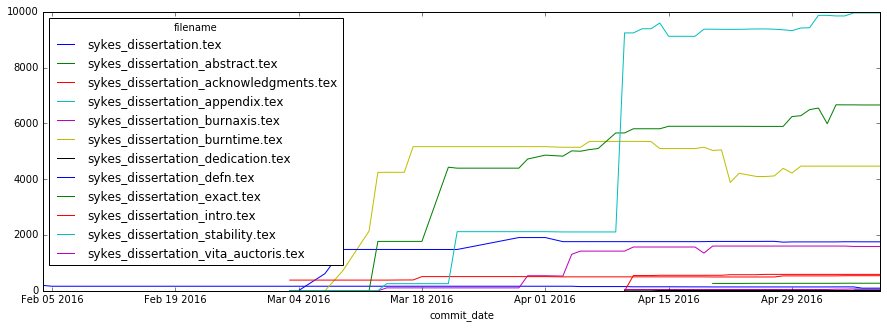

In [299]:
import matplotlib.pyplot as plt
%matplotlib inline

df4.plot(legend = True, figsize = (15,5))

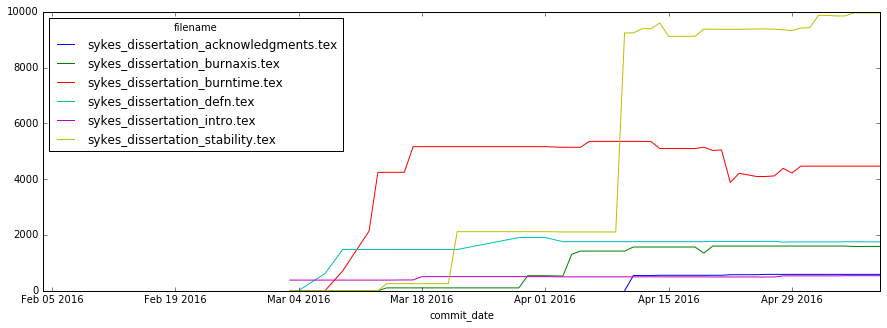

In [304]:
# Select the main sections of my dissertation
cols = ['sykes_dissertation_acknowledgments.tex','sykes_dissertation_burnaxis.tex','sykes_dissertation_burntime.tex',
 'sykes_dissertation_defn.tex','sykes_dissertation_intro.tex','sykes_dissertation_stability.tex']

# Plot them!
df4[cols].plot(legend = True, figsize = (15,5))

# The stability has other branches that weren't considered in this, so it appears to have a massive jump.  Could probably go back and add in those, or just aggregate this shit up to a weekly level and make a nice line chart.  Write up a blog post highlighting the use of gitpython and subprocess to get the word counts